In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [3]:
data = data_noiseless
err = data_all[:,1::2] / np.std(data, ddof = 1, axis=0)
proc_data = (data - np.mean(data, axis=0)) / np.std(data, ddof = 1, axis=0)

In [ ]:
som = MiniSom(50, 50, proc_data.shape[1], sigma = 0.8, learning_rate = 0.4, activation_distance = "chi2_distance")
som.random_weights_init(proc_data)
som.train(proc_data, errs = err, num_iteration =  1, use_epochs = True)

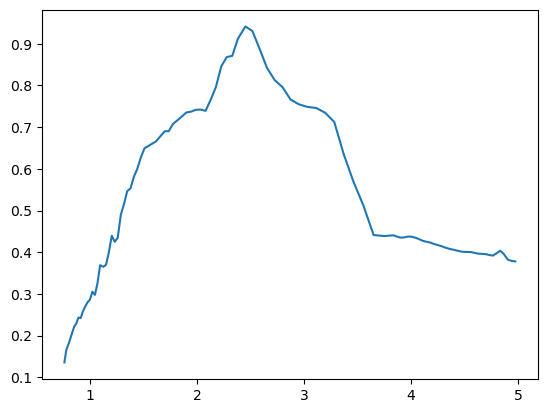

In [23]:
idx = 9614
plt.plot(wl, data_noiseless[idx]/1000, label='noiseless/1000')

<ErrorbarContainer object of 3 artists>

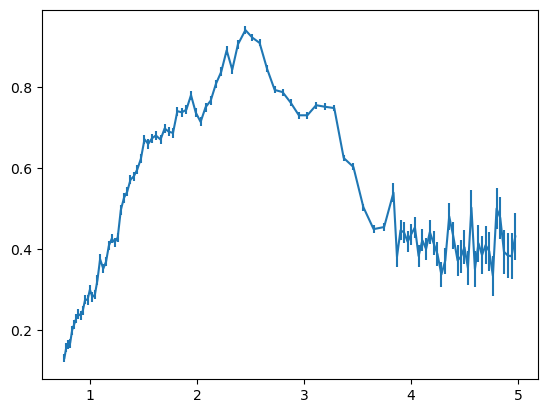

In [13]:
plt.errorbar(wl, data_all[idx,0::2], data_all[idx,1::2], label='all-sky')

<ErrorbarContainer object of 3 artists>

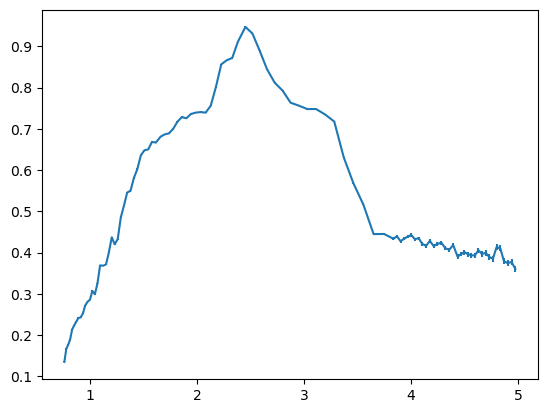

In [14]:
plt.errorbar(wl, data_deep[idx,0::2], data_deep[idx,1::2], label='deep')